In [1]:
from cnp.data import EEGGenerator

import torch

import numpy as np
import matplotlib.pyplot as plt

from cnp.cnp import (
    GaussianNeuralProcess,
    StandardEEGConvGNP
)

from cnp.cov import (
    MultiOutputMeanFieldGaussianLayer,
    MultiOutputInnerprodGaussianLayer,
    MultiOutputKvvGaussianLayer
)

from cnp.encoders import ConvEEGEncoder
from cnp.decoders import ConvEEGDecoder

from cnp.architectures import UNet

In [2]:
batch_size = 8
batches_per_epoch = 256
num_total_channels = 6
num_target_channels = 3
target_length = 50

train = EEGGenerator(split='train',
                     batch_size=batch_size,
                     batches_per_epoch=batches_per_epoch,
                     num_total_channels=num_total_channels,
                     num_target_channels=num_target_channels,
                     target_length=target_length,
                     device=None)

valid = EEGGenerator(split='valid',
                     batch_size=batch_size,
                     batches_per_epoch=batches_per_epoch,
                     num_total_channels=num_total_channels,
                     num_target_channels=num_target_channels,
                     target_length=target_length,
                     device=None)

test = EEGGenerator(split='test',
                    batch_size=batch_size,
                    batches_per_epoch=batches_per_epoch,
                    num_total_channels=num_total_channels,
                    num_target_channels=num_target_channels,
                    target_length=target_length,
                    device=None)

torch.Size([8, 256, 1])
torch.Size([8, 6, 256])
torch.Size([8, 6, 256])
torch.Size([8, 50, 1])
torch.Size([8, 6, 50])
torch.Size([8, 6, 50])


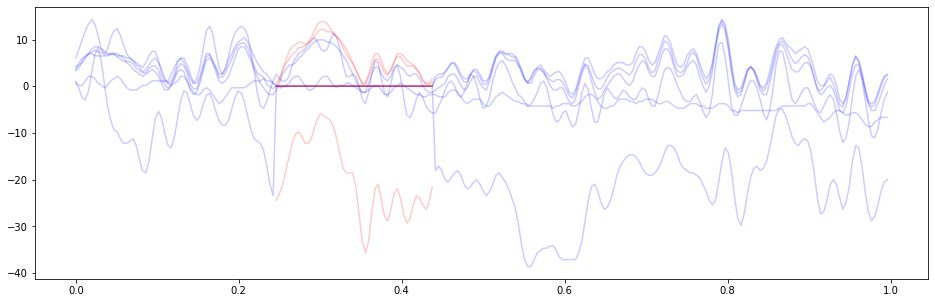

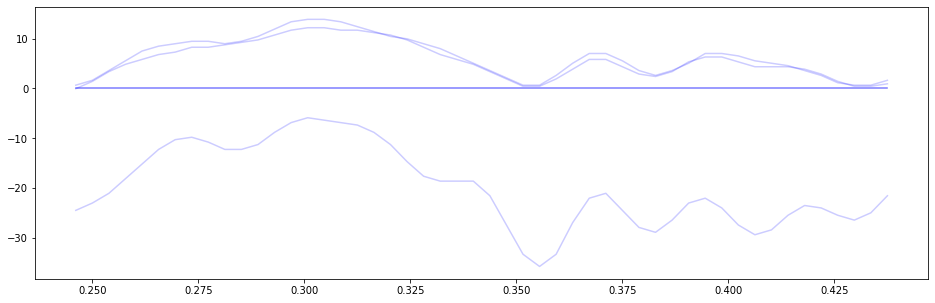

In [3]:
for batch in train:
    
    print(batch['x_context'].shape)
    print(batch['y_context'].shape)
    print(batch['m_context'].shape)
    print(batch['x_target'].shape)
    print(batch['y_target'].shape)
    print(batch['m_target'].shape)
    
    for xc, yc, xt, yt in zip(batch['x_context'],
                              batch['y_context'],
                              batch['x_target'],
                              batch['y_target']):
        
        plt.figure(figsize=(16, 5))
        plt.plot(xc[:, 0], yc.T, color='blue', alpha=0.2)
        plt.plot(xt[:, 0], yt.T, color='red', alpha=0.2)
        plt.show()
        
        break
    
    
    for x, y in zip(batch['x_target'], batch['y_target']):
        
        plt.figure(figsize=(16, 5))
        plt.plot(x[:, 0], y.T, color='blue', alpha=0.2)
        plt.show()
        
        break
        
    break

In [4]:
num_channels_context = 6
cnn_out_features = 7
init_length_scale = 1e-2
out_features = 2

conv_architecture = UNet(input_dim=1,
                         in_channels=num_channels_context,
                         out_channels=cnn_out_features)

encoder = ConvEEGEncoder(num_channels_context=num_channels_context)

decoder = ConvEEGDecoder(in_features=cnn_out_features,
                         out_features=out_features,
                         num_channels=num_channels_context,
                         conv_architecture=conv_architecture,
                         init_length_scale=init_length_scale)

In [5]:
num_outputs = 6
jitter = 1e-6

output_layer = MultiOutputMeanFieldGaussianLayer(num_outputs=num_outputs,
                                                 jitter=jitter)

tensor = encoder.forward(y_context=batch['y_context'],
                         m_context=batch['m_context'])

tensor = decoder.forward(r=tensor,
                         x_context=batch['x_context'],
                         x_target=batch['x_target'])

print(tensor.shape, batch['m_target'].shape)

result = output_layer._mean_and_cov(tensor=tensor,
                                    target_mask=batch['m_target'])
mean, f_cov, y_cov = result

print(mean.shape, f_cov.shape, y_cov.shape)


result = output_layer.mean_and_cov(tensor=tensor,
                                   target_mask=batch['m_target'],
                                   double=True)
mean, f_cov, y_cov = result

print(mean.shape, f_cov.shape, y_cov.shape)

loglik = output_layer.loglik(tensor=tensor,
                             y_target=batch['y_target'],
                             target_mask=batch['m_target'],
                             double=True)

print(loglik.shape)

result = output_layer.sample(tensor=tensor,
                             target_mask=batch['m_target'],
                             num_samples=10,
                             noiseless=True,
                             double=True)
samples, samples_masked = result

print(samples.shape, samples_masked.shape)

torch.Size([8, 6, 50, 2]) torch.Size([8, 6, 50])
torch.Size([8, 150]) torch.Size([8, 150, 150]) torch.Size([8, 150, 150])
torch.Size([8, 150]) torch.Size([8, 150, 150]) torch.Size([8, 150, 150])
torch.Size([8])
torch.Size([10, 8, 6, 50]) torch.Size([10, 8, 3, 50])


In [6]:
num_outputs = 6
num_embedding = 32
noise_type = 'homo'
jitter = 1e-6

output_layer = MultiOutputInnerprodGaussianLayer(num_outputs=num_outputs,
                                                 num_embedding=num_embedding,
                                                 noise_type=noise_type,
                                                 jitter=jitter)

conv_architecture = UNet(input_dim=1,
                         in_channels=num_channels_context,
                         out_channels=cnn_out_features)

encoder = ConvEEGEncoder(num_channels_context=num_channels_context)

decoder = ConvEEGDecoder(in_features=cnn_out_features,
                         out_features=output_layer.num_features,
                         num_channels=num_channels_context,
                         conv_architecture=conv_architecture,
                         init_length_scale=init_length_scale)


tensor = encoder.forward(y_context=batch['y_context'],
                         m_context=batch['m_context'])

tensor = decoder.forward(r=tensor,
                         x_context=batch['x_context'],
                         x_target=batch['x_target'])

print(tensor.shape, batch['m_target'].shape)

result = output_layer._mean_and_cov(tensor=tensor,
                                    target_mask=batch['m_target'])
mean, f_cov, y_cov = result

print(mean.shape, f_cov.shape, y_cov.shape)


result = output_layer.mean_and_cov(tensor=tensor,
                                   target_mask=batch['m_target'],
                                   double=True)
mean, f_cov, y_cov = result

print(mean.shape, f_cov.shape, y_cov.shape)

loglik = output_layer.loglik(tensor=tensor,
                             y_target=batch['y_target'],
                             target_mask=batch['m_target'],
                             double=True)

print(loglik.shape)

result = output_layer.sample(tensor=tensor,
                             target_mask=batch['m_target'],
                             num_samples=10,
                             noiseless=True,
                             double=True)
samples, samples_masked = result

print(samples.shape, samples_masked.shape)

torch.Size([8, 6, 50, 33]) torch.Size([8, 6, 50])
torch.Size([8, 150]) torch.Size([8, 150, 150]) torch.Size([8, 150, 150])
torch.Size([8, 150]) torch.Size([8, 150, 150]) torch.Size([8, 150, 150])
torch.Size([8])
torch.Size([10, 8, 6, 50]) torch.Size([10, 8, 3, 50])


In [7]:
num_outputs = 6
num_embedding = 32
noise_type = 'homo'
jitter = 1e-4

output_layer = MultiOutputKvvGaussianLayer(num_outputs=num_outputs,
                                           num_embedding=num_embedding,
                                           noise_type=noise_type,
                                           jitter=jitter)

conv_architecture = UNet(input_dim=1,
                         in_channels=num_channels_context,
                         out_channels=cnn_out_features)

encoder = ConvEEGEncoder(num_channels_context=num_channels_context)

decoder = ConvEEGDecoder(in_features=cnn_out_features,
                         out_features=output_layer.num_features,
                         num_channels=num_channels_context,
                         conv_architecture=conv_architecture,
                         init_length_scale=init_length_scale)

tensor = encoder.forward(y_context=batch['y_context'],
                         m_context=batch['m_context'])

tensor = decoder.forward(r=tensor,
                         x_context=batch['x_context'],
                         x_target=batch['x_target'])

print(tensor.shape, batch['m_target'].shape)

result = output_layer._mean_and_cov(tensor=tensor,
                                    target_mask=batch['m_target'])
mean, f_cov, y_cov = result

print(mean.shape, f_cov.shape, y_cov.shape)


result = output_layer.mean_and_cov(tensor=tensor,
                                   target_mask=batch['m_target'],
                                   double=True)
mean, f_cov, y_cov = result

print(mean.shape, f_cov.shape, y_cov.shape)

loglik = output_layer.loglik(tensor=tensor,
                             y_target=batch['y_target'],
                             target_mask=batch['m_target'],
                             double=True)

print(loglik.shape)

result = output_layer.sample(tensor=tensor,
                             target_mask=batch['m_target'],
                             num_samples=10,
                             noiseless=True,
                             double=True)
samples, samples_masked = result

print(samples.shape, samples_masked.shape)

torch.Size([8, 6, 50, 34]) torch.Size([8, 6, 50])
torch.Size([8, 150]) torch.Size([8, 150, 150]) torch.Size([8, 150, 150])
torch.Size([8, 150]) torch.Size([8, 150, 150]) torch.Size([8, 150, 150])
torch.Size([8])
torch.Size([10, 8, 6, 50]) torch.Size([10, 8, 3, 50])


In [15]:
num_outputs = 6
num_embedding = 32
noise_type = 'homo'
jitter = 1e-4

output_layer = MultiOutputKvvGaussianLayer(num_outputs=num_outputs,
                                           num_embedding=num_embedding,
                                           noise_type=noise_type,
                                           jitter=jitter)

model = StandardEEGConvGNP(num_channels_context=num_outputs,
                           output_layer=output_layer)

_ = model.forward(x_context=batch['x_context'],
                  y_context=batch['y_context'],
                  m_context=batch['m_context'],
                  x_target=batch['x_target'])


loss = model.loss(x_context=batch['x_context'],
                  y_context=batch['y_context'],
                  m_context=batch['m_context'],
                  x_target=batch['x_target'],
                  y_target=batch['y_target'],
                  m_target=batch['m_target'])

samples, samples_masked = model.sample(x_context=batch['x_context'],
                                       y_context=batch['y_context'],
                                       m_context=batch['m_context'],
                                       x_target=batch['x_target'],
                                       m_target=batch['m_target'],
                                       num_samples=10,
                                       noiseless=True,
                                       double=True)

print(samples.shape, samples_masked.shape)

result = model.mean_and_marginals(x_context=batch['x_context'],
                                  y_context=batch['y_context'],
                                  m_context=batch['m_context'],
                                  x_target=batch['x_target'],
                                  m_target=batch['m_target'])

mean, var, var_plus_noise = result

print(mean.shape, var.shape, var_plus_noise.shape)

torch.Size([10, 8, 6, 50]) torch.Size([10, 8, 3, 50])
torch.Size([8, 150]) torch.Size([8, 150]) torch.Size([8, 150])
